# [Introduction: Manual Feature Engineering](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Introduction:-Manual-Feature-Engineering)

당신이 이 대회에 처음이라면, 저는 이 시작하기 위해 이 notebook을 확인하는 것을 추천합니다.

이 notebook에서는 HomeCredit Default Risk competition을 위해 직접 feature를 만드는 것을 살펴보겠습니다. 이전 notebook에서는 모델을 만들기 위해서 `application` 데이터만을 사용했습니다. 이 데이터로 부터 만들어진 최고의 모델은 약 0.74의 리더보드 스코어를 달성했습니다. 이 스코어를 향상시키기 위해서 다른 데이터 프레임에서 더 많은 정보를 포함해야 합니다. 여기서 우리는 `bureau` 와 `bureau_balance` 데이터로 부터 정보 사용을 살펴보겠습니다. 이러한 데이터 파일의 정의는 다음과 같습니다.
- bureau : Home credit에 전해준 다른 금융기관에서의 고객의 이전 대출 정보입니다
다른 금융 기관과의 고객의 이전 대출에 대한 정보가 홈 크레딧에 보고되었습니다. 이전 대출은 각각 자체 행이 있습니다.
- bureau_balance : 이전 대출에 대한 월별 정보입니다. 매달 행이 하나씩 있습니다.


 수작업 feature engineering은 지루한 과정이 될 수 있고 (이것이 우리가 featuretools와 같은자동화된 feature engineering 사용하는 이유입니다.) 종종 도메인 전문 지식에 의존합니다. 그래서 저는 대출과 무엇이 사람을 채무불이행 할 수 있는지에 대한 도매인 지식이 한정되기 때문에 대신 최종 training 데이터 프레임에 최대한 많은 정보를 얻는 데 집중할 것입니다. 그러면 모델은 우리가 그것을 결정하는 것보다 어떤 feature이 중요한지 알게 될 것입니다. 기본적으로 우리의 접근방식은 가능한한 많은 feature를 만들고 그 모든 feature들을 모델에게 사용하기 위해 제공하는 것입니다! 이후에, 우리는 모델의 변수중요도(feature importances)나 PCA와 같은 다른 기술를 사용한 feature reducteion을 수행할 수 있습니다.

수작업 feature engineering의 과정은 많은 pands 코드, 약간의 인내심, 그리고 
많은 훌륭한 practice manipulation data가 포함됩니다. 자동화된 feature engineering 도구를 사용할 수 있게 되었지만 feature engineering은 여전히 오랜 시간동안 데이터와의 씨름을 통해 이루어집니다.




In [0]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## 예제: 고객의 이전 대출 수

 manual feature engineering의 일반적인 과정을 설명하기 위해서 우리는 먼저 간단하게 고객의 다른 금융기관에서의 이전 대축의 수를 얻어보겠습니다. 이를 위해서는 notebook 전체에 걸쳐서 많은 pandas 연산이 필요합니다.
 

- groupby: 컬럼별로 데이터프레임을 그룹화. 이 경우에는 unique client, SK_ID_CURR 컬럼을 groupby 합니다.
- agg: 컬럼의 평균을 구하는 것과 같이 그룹화된 데이터에 대해 계산을 수행합니다.
우리는 직접 함수(grouped_df.mean())를 호출할 수도 있고 변환 목록과 같이 agg 함수(grouped_df.agg([mean, max, min, sum]))를 사용할수 있습니다.
- merge: 집계된 통계를 적적한 고객과 연결합니다. 우리는 고객이 해당 통계를 가지고 있지 않은 셀에 Nan을 삽입할 `SK_ID_CURR` 컬럼의 계산된 통계와 원본 training 데이터를 병합해야 합니다.

또한 (이름 변경) 함수를 사용하여 dictionary으로 이름을 바꿀 열을 꽤 많이 지정합니다. 이것은 우리가 생성하는 새로운 변수를 추적하는 데 유용합니다.
We also use the (rename) function quite a bit specifying the columns to be renamed as a dictionary. 
이것은 많은 것처럼 보일 수 있습니다. 그래서 우리는 결국 이 과정을 우리를 위해 할 수 있는 함수를 쓸 것입니다. 먼저 이 내용을 직접 손으로 구현해 보겠습니다.
This might seem like a lot, which is why we'll eventually write a function to do this process for us. Let's take a look at implementing this by hand first.


In [0]:
# Read in bureau
bureau = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [0]:
# Groupby the client id (SK_ID_CURR), 이전 대출의 수 count, and 컬럼 이름 재명명
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [0]:
# Join to the training dataframe
train = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


오른쪽 끝까지 스크롤하여 새 컬럼을 확인합니다.

## r value을 가진 새로운 변수의 유용성을 평가

새로운 변수가 유용한지 확인하기 위해서 우리는 이 변수와 target간의 피어슨 상관계수(r value)를 계산할 수 있습니다. 이 값은 주 변수 사이의 선형 관계의 강도를 측정하고 -1(완벽한 음의 선형 관계)부터 1(완벽한 양의 선형 관계)의 범위를 값을 가집니다.  r value는 새로운 변수의 유용성에 대한 최고의 척도는 아니지만 변수가 머신 러닝 모델에 도움이 되는지 여부에 대한 첫번째 근사치를 제공할 수 있습니다. 타겟에 대한 변수의 r value가 클수록 이 변수의 변화는 타겟에 값에 영향을 줄 수 있습니다. 그러므로 우리는 타겟에 비해서 가장 큰 절대값 r value를 찾습니다.

 우리는 커널 밀도 추정(KED)을 사용하여 시각적으로 타겟의 관계를 검사할 수 있습니다. 


### 커널 밀도 추정(KDE) 그래프
 커널 밀도 추정 그래프는 한 변수의 분포를 보여준다(smoothed histogram으로 생각해 봅시다.). 번주형 변수의 값에 따라 분포의 차이를 확인하려면 범주에 따라 분포를 다르게 색칠할 수 있습니다. 예를 들어, 우리는 `target` = 1 인지 0 인지에 따라 색칠된 `previout_loan_count`의 커널 밀도 추정을 볼 수 있습니다. KDE 결과는 대출을 갚지 않은 사람(TARGET=1)과 갚은 사람(TARGET=0) 사이의 변수 분포에서 어떤 중요한 차이를 보여줍니다. 이것은 변수가 머신 러닝 모델과 '관련'되는지 여부를 나타내는 지표의 역할을 할 수 있습니다.

 이 플로팅 기능을 어떤 변수에서도 다시 사용할 수 있는 함수에 넣을 것입니다. 

In [0]:
# Plots the disribution of a variable colored by value of the target

def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

 우리는 이 함수를 랜덤 포레스트와 gradient boosting machine에 따라 가장 중요한 변수 중 하나로 찾은 `EXT_SOURCE_3` 변수를 사용하여 테스트 할 수 있습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


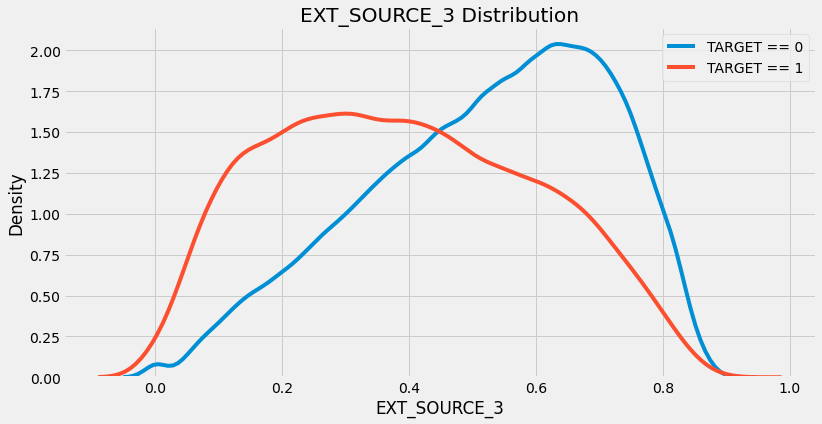

In [0]:
kde_target('EXT_SOURCE_3', train)

이제 방금 만든 새로운 변수의 경우, 다른 기관의 이전 대출 건수입니다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


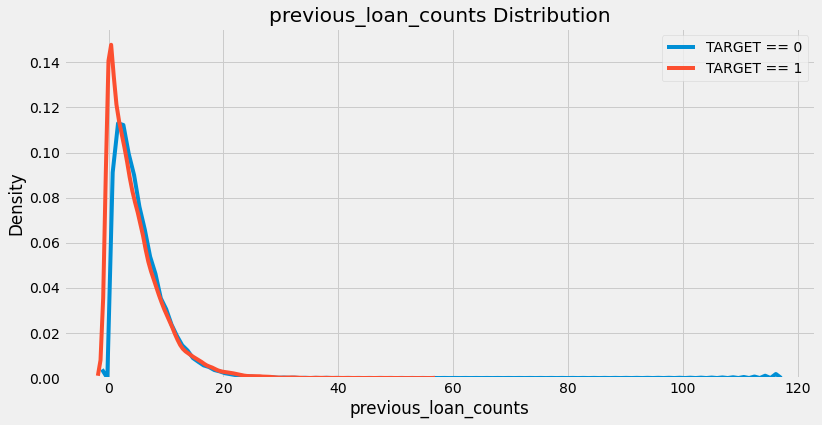

In [0]:
kde_target('previous_loan_counts', train)

 이 그래프를 보면 이 변수는 중요할 거라고 말하기 힘듭니다. 이 상관 계수는 매우 약하고 분포에 뚜렷한 차이가 거의 없습니다.

bureau 데이터 프레임의 몇 가지 변수를 더 만들어 보겠습니다. 우리는 bureau 데이터프레임에서 모든 숫자 컬럼의 `mean`, `min`, 그리고 `max`를 가지고 오겠습니다.

## 숫자 컬럼 집계

 bureau 데이터 프레임의 숫자 정보를 설명하기 위해서 우리는 모든 숫자 컬럼의 통계값을 계산할 수 있습니다. 그렇게 하기 위해서 우리는 client id로 그룹화, 그룹화된 데이터프레임을 집계, 그리고 training 데이터로 다시 결과를 합칩니다. `agg` 함수는 작업이 유효하다고 간주되는 숫자 컬럼에서만 값을 계산할 수 있습니다. 우리는 `mean`, `max`, `min`, `sum` 사용할 예정이지만 여기에는 어떤 함수도 넘겨질 수 있습니다.  우리는 심지어 우리 자신의 함수를 작성하고 agg 호출에서 사용합니다.

In [0]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                    ...  AMT_ANNUITY                       
                   count         mean  max  ...         mean      max  min      sum
0     100001           7  -735.000000  -49  ...  3545.357143  10822.5  0.0  24817.5
1     100002           8  -874.000000 -103  ...     0.000000      0.0  0.0      0.0
2     100003           4 -1400.750000 -606  ...          NaN      NaN  NaN      0.0
3     100004           2  -867.000000 -408  ...          NaN      NaN  NaN      0.0
4     100005           3  -190.666667  -62  ...  1420.500000   4261.5  0.0   4261.5

[5 rows x 61 columns]

 우리는 각 컬럼에 새로운 이름을 지어야 합니다. 다음 코드는 이름에 통계를 덧붙여 새로운 이름을 만듭니다. 여기서 우리는 데이터프레임은 multi-level index를 가지고 있다는 사실을 다뤄야 합니다. 저는 이런 것들이 혼란스럽고 다루기 힘들다고 생각하기 때문에 가능한 한 빨리 single level index로 줄이려고 노력합니다.

In [0]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [0]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이제 우리는 간단하게 이전에 우리가 했던 것처럼 training 데이터를 합치겠습니다.

In [0]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,

### 집계된 값과 타겟의 상관 관계

우리는 모든 새로운 값과 타겟 사이의 상관관계를 계산할 수 있습니다. 다시 말하면, 모델링을 위해 중요할 수 있는 변수의 근사치로 사용할 수 있습니다.

In [0]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

 아래의 코드에서 우리는 파이썬 함수 `sorted`를 사용하여 크기(절대값)에 따라 상관관계를 정렬합니다. 우리는 또한 다른 중요한 알면 좋은 파이썬 연산인 람다를 이용합니다.

In [0]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115894),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730155),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306002),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495)]

새 변수 중 TARGET과 유의한 상관 관계가 있는 변수는 없습니다. 우리는 가장 깊은 상관 관계가 있는 변수인 'bureau_DAYS_CREDIT_mean'의 KDE 그래프를 상관 관계 측면에서 목표값과 함께 볼 수 있습니다.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


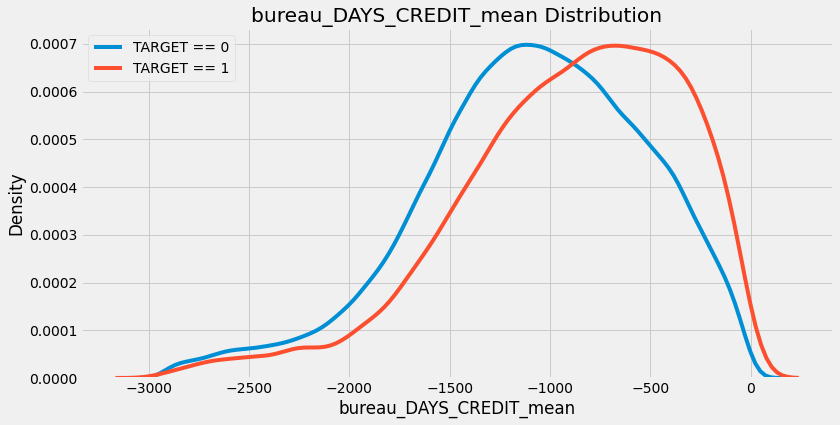

In [0]:
kde_target('bureau_DAYS_CREDIT_mean', train)

 이 컬럼의 정의는 "고객이 현재 신청 전에 얼마나 많이 신용 기관에 대출을 신청했는지?"이다. Home Credit에서 대출을 위한 신청 전에 이전 대출이 신청된 일수라고 해석됩니다. 그러므로 큰 음수가 클수록 대출이 이전 대출이 현재 대출 신청 보다 더 이전임을 나타냅니다. 우리는 이 변수의 평균과 과거에 대출을 더 신청했던 고객이 home credit에서 대출금을 상환할 가능성이 높다는 의미 사이에 매우 약한 양의 관계를 확인했습니다. 그러나 상관 관계가 이렇게 약하면 신호만큼 노이즈가 발생할 가능성이 높습니다.

### [다중 비교 문제](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#The-Multiple-Comparisons-Problem)

 변수가 많을 때는 순전히 우연으로 상관관계가 있을 경우도 예상할 수 있는데, 이는 [다중 비교](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578)라고 알려진 문제입니다. 우리는 수 백개의 feature들을 만들 수 있고 어떤 feature는 데이터의 random noise 때문에 target과의 상관관계가 나타날 수 있습니다. 그러면 우리 모델을 학습할 때, training set의 target과 관계가 있다고 생각하기 때문에 이러한 변수들이 과대적합될 수 있지만 이것이 반드시 test set에 일반화되는 것은 아닙니다. feature를 만들 때 여러가지 고려해야할 사항들이 있습니다.

## [숫자 집계를 위한 함수](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Function-for-Numeric-Aggregations)

 이전의 모든 작업을 하나의 함수로 캡슐화해 보겠습니다. 이것은 모든 데이터프레임에 숫자형 컬럼에 대한 집계 통계를 계산할 수 있을 것 입니다. 다른 데이터프레임들에 같은 연산이 적용되기를 원할 때 이 함수를 재사용할 수 있을 것입니다.

In [0]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [0]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


함수가 의도대로 작동했는지 확실히 하기 위해서 우리는 직접 만든 집계된 데이터프레인과 비교해야 합니다.

In [0]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


만약 우리가 그 값들을 조사해 보면, 우리는 그것들이 같다는 것을 알게 됩니다. 다른 데이터 프레임의 숫자 통계 계산에 이 기능을 재사용할 수 있습니다. 함수를 사용하면 일관된 결과를 얻을 수 있으며 앞으로 해야 할 작업의 양을 줄일 수 있습니다!

### 상관관계 함수

 다음으로 넘어가기 전에 우리는  target과의 상관관계를 계산하기 위한 코드를 함수로 만들 수 있습니다.


In [0]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### 범주형 변수

 이제 숫자형 컬럼에서 범주형 컬럼으로 넘어가겠습니다. 범주형 변수는 이산적인 문자열 변수입니다. 그래서 우리는 숫자형 컬럼에서만 작동하는 `mean`과 `max`와 같은 통계량을 계산할 수 없습니다. 대신에 각 범주형 변수 내에서 각 범주의 값 카운트를 계산합니다.

 예를 들어 다음 데이터프레임을 가지고 있다면


SK_ID_CURR	| Loan type
:---:| :---:
1|	home
1|	home
1|	home
1|	credit
2|	credit
3|	credit
3|	cash
3|	cash
4|	credit
4|	home
4|	home

 우리는 각 고객에 대한 각 범주에서 대출의 수를 세는 이 정보를 사용할 것입니다.

SK_ID_CURR | credit count | cash count | home count | total count
:---:|:---:|:---:|:---:|:---:
1|	1|	0|	3|	4
2|	1|	0|	0|	1
3|	1|	2|	0|	3
4|	1|	0|	2|	3

그러면 우리는 이 count해당 관측치에 대한 범주형 변수의 총 발생 횟수로 정규화할 수 있습니다.(각 관측치에 대해 정규화된 카운트의 합이 1.0이어야 함을 의미합니다.)


SK_ID_CURR|credit count|cash count|home count|total count|credit count norm|cash count norm|home count norm
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
1|	1|	0|	3|	4|	0.25|	0|	0.75
2|	1|	0|	0|	1|	1.00|	0|	0
3|	1|	2|	0|	3|	0.33|	0.66|	0
4|	1|	0|	2|	3|	0.33|	0|	0.66

이러한 방식으로 범주형 변수를 인코딩하면 범주형 변수가 포함하는 정보를 캡처할 수 있습니다. 이 과정에 대해 더 좋은 아이디어가 있다면 댓글로 알려주세요! 이제 이 과정을 단계별로 진행하겠습니다. 마지막으로, 모든 코드를 하나의 함수로 정리하여 많은 데이터 프레임에 다시 사용할 수 있도록 하겠습니다.

먼저 우리는 범주형 컬럼(dtype == `object`)만 포함한 데이터프레임을 one-hot 인코딩을 하겠습니다.

In [0]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354


In [0]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active            ... CREDIT_TYPE_Unknown type of loan     
                            sum      mean  ...                              sum mean
SK_ID_CURR                                 ...                                      
100001                        3  0.428571  ...                                0  0.0
100002                        2  0.250000  ...                                0  0.0
100003                        1  0.250000  ...                                0  0.0
100004                        0  0.000000  ...                                0  0.0
100005                        2  0.666667  ...                                0  0.0

[5 rows x 46 columns]

`sum` 컬럼은 연결된 고객에 대한 해당 번주의 카운트를 나타내고 `mean` 컬럼은 nomalized 카운트를 나타냅니다. one-hot 인코딩은 이러한 수치를 계산하는 과정을 매우 쉽게 만듭니다.

우리는 이전과 유사한 기능을 사용하여 열 이름을 변경할 수 있습니다. 다시 말하자면 우리는 컬럼을 위해 multi-level 인덱스를 다뤄야 합니다. 범주 값(one-hot 인코딩으로부터의)에 추가된 범주형 변수의 이름인 첫 번째 level(level 0)을 반복합니다.그리고 우리가 계산한 각 고객의 통계에 반복합니다. 우리는 통계값으로 투가된 level 0 이름의 컬럼을 재명명합니다. 예를들어, level 0로서의 `CREDIT_ACTIVE_Active`과 level 1으로서의 `sum` 컬럼이 `CREDIT_ACTIVE_Active_count`가 됩니다.

In [0]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [0]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [0]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


`sum` 컬럼은 count를 기록하고 `mean` 컬럼은 normalized된 count를 기록합니다.

우리는 이 데이터프레임을 training 데이터에 합칩니다.

In [0]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.5,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.5,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,

In [0]:
train.shape

(307511, 229)

In [0]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,...,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,6.0,-349.000000,780.0,-1072.0,-2094.0,6.0,-697.500000,-36.0,-1185.0,-4185.0,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.200000,245781.0,0.0,245781.0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.500000,4.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,4.0,-544.500000,1216.0,-2434.0,-2178.0,3.0,-1097.333333,-540.0,-2131.0,-3292.0,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.500000,2.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,2.0,-488.500000,-382.0,-595.0,-977.0,2.0,-532.500000,-382.0,-683.0,-1065.0,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### 범주형 변수를 다루기 위한 함수

 코드를 조금 더 효율적으로 만들기 위해서 우리는 이제 범주형 변수를 다루기 위한 함수를 작성할 수 있습니다.이는 데이터 프레임 및 그룹화 변수를 수용한다는 점에서 `agg_numeric` 함수와 동일한 형태를 띱니다. 그리고 이 함수는 데이터프레임의 모든 범주형 변수에 대해서 각 범주의 count와 normalized count를 계산할 수 있습니다.

In [0]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # 범주형 변수 선택
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # 식별 id를 컬럼에 표시
    categorical[group_var] = df[group_var]

    # group var를 Grouby하고 sum과 mean을 계산
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical


In [0]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


#### 다른 데이터프레임에 연산 적용하기

 이제 bureau balance 데이터프레임을 보겠습니다. 이 데이터프레임은 각 다른 고객의 다른 기관에서의 월별 이전 대출 정보를 가지고 있습니다. 이 데이터 프레임을 고객 ic인 `SK_ID_CURR`로 그룹화하는 것 대신에 우리는 먼저 이 데이터프레임을 이전 대출의 id인 `SK_ID_BUREAU`로 그룹화하겠습니다. 이것은 각 대출마다 데이터프레임 한 row를 우리에게 제공합니다. 그리고 나서 `SK_ID_CURR`로 그룹화를 하고 각 고객들의 대출에 대한 집계를 계산합니다.최종 결과는 각 클라이언트에 대해 하나의 행이 있는 대출에 대한 통계를 계산한데이터 프레임입니다.

In [0]:
# bureau balance 파일 읽기

bureau_balance = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저 각 대출에 대한 status 값 count를 계산합니다. 운이 좋게도 우리는 이미 이것을 할 수 있는 함수를 가지고 있습니다.

In [0]:
# 각 이전 대축에 해한 status 타입을 count
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


 이제 우리는 숫자형 컬럼을 다룰 수 있다. `MONTH_BALANCE` 컬럼은 신청 날짜와 관련된 잔액 개월이 있습니다. 이는 숫자 변수만큼 중요하지 않을 수 있으며, 향후 작업에서는 시간 변수로 고려해야 할 수도 있습니다. 현재로서는 이전처럼 집계 통계량만 계산할 수 있습니다.

In [0]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


 위의 데이터프레임들은 각 대출에 대해 계산합니다. 이제 각 고객에 대해서 집계해야 합니다. 먼저 데이터 프레임을 병합한 다음 모든 변수가 숫자형이므로 이번에는 `SK_ID_CURR`로 그룹화하여 통계를 다시 집계하면 됩니다.

In [0]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [0]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_STATUS_0_count_count,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_count,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_count,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,...,client_bureau_balance_STATUS_4_count_count,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_count,client_bureau_balance_STATUS_4_count_norm_mean,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_count,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_C_count_norm_count,client_bureau_balance_STATUS_C_count_norm_mean,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_C_count_norm_min,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,7,0.0,0,0,0,7,-23.571429,-1,-51,-165,7,-400.000000,-1,-1326,-2800,7,4.428571,12,1,31.0,7,0.336651,1.000000,0.019231,2.356557,7,0.142857,1,0,...,7,0.0,0,0,0,7,0.0,0.0,0.0,0.0,7,0.0,0,0,0.0,7,0.0,0.0,0.0,0.0,7,15.714286,44,0,110.0,7,0.441240,0.966667,0.000000,3.088683,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,8,-15.5,0,-3

`bureau_balance dataframe` 데이터프레임을 요약하면

1. 각 대출로 그룹화한 계산된 숫자 통계량
2. 만들어진 대출로 그룹화된 각 범주형 변수 값 count
3. 병합된 통계량과 대출에 값 counts
4. 고객 id로 그룹화된 결과 데이터프레임에 대한 계산된 숫자 통계

마지막 결과 데이터프레임은 각 고객에 마다 한 row를 가지고 있으며, 모든 대출에 대해 월별 잔액 정보가 계산됩니다.

이 변수의 일부는 조금 혼란스럽습니다. 그럼 몇 가지 설명을 해볼까요 

- `client_bureau_balance_MONTHS_BALANCE_mean_mean`: 각 대출에 대해서 `MONTHS_BALANCE`의 평균 값을 계산합니다. 그리고 각 고객에 대해서 모든 대출의 평균을 계산합니다.
- `client_bureau_balance_STATUS_X_count_norm_sum`: 각 대출에 대해서 `STATUS == x`의 발생 횟수를 대출에 대한 총 'STATUS' 값 수로 나눈 값을 계산합니다.

모든 변수가 하나의 데이터 프레임에 결합될 때까지 상관 관계 계산을 보류하겠습니다.

# 함수 통합하기

우리는 이제 다른 기관의 이전 대출과 이러한 대출에 대한 월별 지급 정보를 가져와서 주요 교육 데이터 프레임에 넣을 수 있는 모든 자료를 준비했습니다. 모든 변수를 리셋한 다음 구축된 기능을 사용하여 처음부터 다시 살펴보겠습니다. 이는 반복 가능한 워크플로우에 기능을 사용할 경우의 이점을 보여줍니다!


In [0]:
# 이전 object를 삭제하여 메모리를 확보
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

12950

In [0]:
train = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/application_train.csv')
bureau = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/bureau_balance.csv')

### Bureau 데이터프레임의 count

In [0]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Bureau 데이터프레임의 집계된 통계량

In [0]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### 대출에 대한 Bureau Balance 데이터프레임의 값 count

In [0]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### 대출별 Bureau Balance 데이터프레임의 집계된 통계량


In [0]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### 각 고객별 Bureau Balance의 집계된 통계량

In [0]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## 계산된 Feature를 training data에 넣기


In [0]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [0]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [0]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Feature Engineering 결과

 모든 작업이 끝난 후, 이제 우리가 만든 변수를 살펴보려고 합니다. 우리는 결측치의 백분율, 타겟에 대한 변수의 상관 관계, 그리고 다른 변수들에 대한 변수의 상관 관계를 살펴볼 수 있습니다. 변수 간의 상관 관계는 우리가 collinear 변수, 즉 서로 높은 상관 관계를 갖는 변수를 보여줄 수 있습니다. 두 변수를 모두 가지고 있는 것은 중복이기 때문에 보통 colinear 변수 중 하나를 제거하기 원합니다. 또한 결측값의 백분율을 사용하여 존재하지 않는 값의 상당 부분이 있는 feature를 제거할 수 있습니다. Feature selection은 앞으로 중요한 초점이 될 것입니다. 피쳐 수를 줄이면 모델이 학습하는 데 도움이 될 수 있고 testing data에 대한 일반화에도 도움이 될 수 있기 때문입니다. "차원의 저주(curse of dimensionality)"는 너무 많은 feature(너무 높은 차원)를 가짐으로써 발생한 문제로 주어진 이름입니다. 변수의 수가 증가하면 이러한 변수와 목표값 간의 관계를 학습하는 데 필요한 데이터 포인트의 수가 기하급수적으로 증가합니다.

 Feature selection은 모델을 학습하고 테스트 세트에 대해 더 잘 일반화하는 데 도움이 되는 변수를 제거하는 과정입니다. 목표는 유용한 변수를 보존하면서 불필요하고 중복된 변수를 제거하는 것입니다. 이 과정을 위해 우리가 사용할 수 있는 수 많은 tool이 있지만 이 notebook에서는 서로 높은 상관 관계를 가진 변수들과 결측값의 비율이 높은 컬럼을 제거하는 작업을 계속하겠습니다. 나중에 Gradient Boosting Machine 또는 Random Forest와 같은 모델에서 반환된 변수 중요도를 사용하여 feature selection을 수행할 수 있습니다.

## Missing Values

중요한 고려사항은 데이터프레임에 있는 결측값입니다. 너무 많은 결측값이 있는 컬럼은 제외합니다.



In [0]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
missing_train = missing_values_table(train)
missing_train.head(100)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
...,...,...
ELEVATORS_MEDI,163891,53.3
WALLSMATERIAL_MODE,156341,50.8
APARTMENTS_MEDI,156061,50.7
APARTMENTS_AVG,156061,50.7


결측값 비율이 높은 컬럼이 있습니다. 결측값을 제거하기 위한 제대로 설정된 임계값이 없으며 문제에 따라 최상의 작업 과정이 달라집니다. 여기서는 피쳐 수를 줄이기 위해 결측값이 90% 이상인 교육 또는 테스트 데이터의 열을 제거합니다.

In [0]:
# 참고

missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 60])
len(missing_train_vars)

83

In [0]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

 결측값을 제거하기 전에 testing 데이터에서 결측값의 비율을 
알아보겠습니다. 그 후 trainging과 testing 데이터 둘 모두에서 결측값이 90% 이상인 컬럼을 제거하겠습니다. 이제 testing 데이터를 읽고 동일한 작업을 수해앟고 testing 데이터의 결측값을 확인하겠습니다. 모든 count 및 집계 통계를 이미 계산했으므로 테스트 데이터만 적절한 데이터와 병합하면 됩니다.

## [Testing 데이터를 위한 정보 계산하기](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Calculate-Information-for-Testing-Data)

In [0]:
# Read in the test dataframe
test = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [0]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


testing 및 trining 데이터 프레임을 정렬해야 합니다. 즉, 열을 일치시켜 동일한 컬럼을 갖도록 해야 합니다. 여기서 문제가 되지는 않겠지만, 변수에 one-hot 인코딩을 사용할 때 우리는 데이터 프레임을 정렬하여 동일한 컬럼을 가지도록 해야 합니다.

In [0]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [0]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


 데이터프레임들은 이제 동일한 컬럼을 가지고 있습니다(training 데이터에서 `TARGET` 컬럼을 제외). traing 및 testing 데이터프레임에서 동일한 컬럼을 확인해야하는 머신러닝 모델에서 사용할 수 있습니다.
 
 이제 검사 데이터에서 결측값의 백분율을 확인하여 삭제할 열을 알아 보겠습니다.

In [0]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [0]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [0]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [0]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

결측값이 90%를 초과하는 열이 없기 때문에 이 라운드에서 열을 제거하지 못했습니다.차원을 줄이기 위해 다른 feature selection 방법을 적용해야 할 수도 있습니다.


이 때 교육 및 테스트 데이터를 모두 저장할 것입니다. 누락된 열을 삭제하고 결과를 비교하기 위해 다른 백분율을 시도해 보시기 바랍니다.

In [0]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## 상관 관계

 먼저 타겟과 변수들 간의 상관 관계를 살펴보겠습니다. 우리가 만든 변수 중 어떤 것에서도 training 데이터에 이미 있는 변수보다 상관 관계가 크다는 것을 알 수 있습니다. (from `application`).

In [0]:
# 데이터프레임에 모든 상관관계를 계산합니다.
corrs = train.corr()

In [0]:
corrs = corrs.sort_values('TARGET', ascending = False)

# 양의 상관관계가 가장 큰 10개
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [0]:
# 음의 상관관계가 가장 큰 10개
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


 타겟과 가장 큰 상관 관계를 가진 변수(물론 상관 관계가 1인 TARGET 외에)는 우리가 만든 변수입니다. 그러나 변수가 상관관계가 있다고 해서 유용하게 쓰일 수 있는 것은 아니며, 수백 개의 새로운 변수를 생성한다면, 무작위 노이즈 때문에 목표값과 상관 관계가 있는 경우도 있다는 점을 기억해야 합니다.
 
 상관 관계를 회의적으로 보면 새로 생성된 여러 변수가 유용할 수 있습니다. 변수의 "유용성"을 평가하기 위해서 우리는 모형이 반환하는 feature 중요도를 보도록 하겠습니다. 호기심 때문에(그리고 이미 함수를 작성했기 때문에) 새로 생성된 변수 2개를 kde plot으로 만들겠습니다.

In [0]:
list(train.columns)

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid =     25.1429


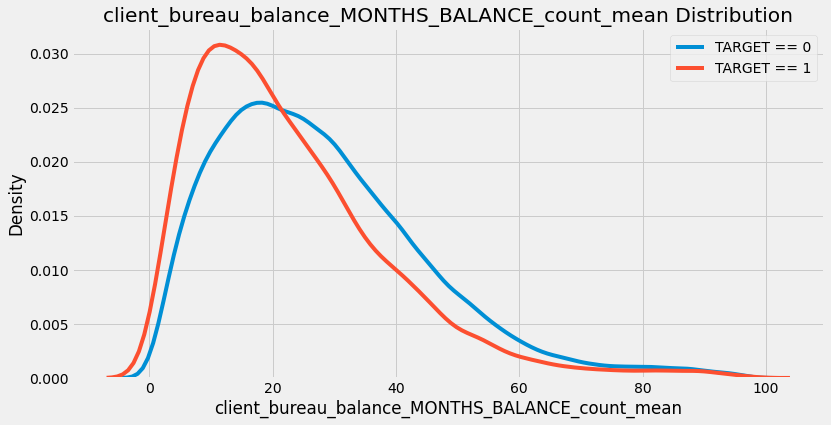

In [0]:
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


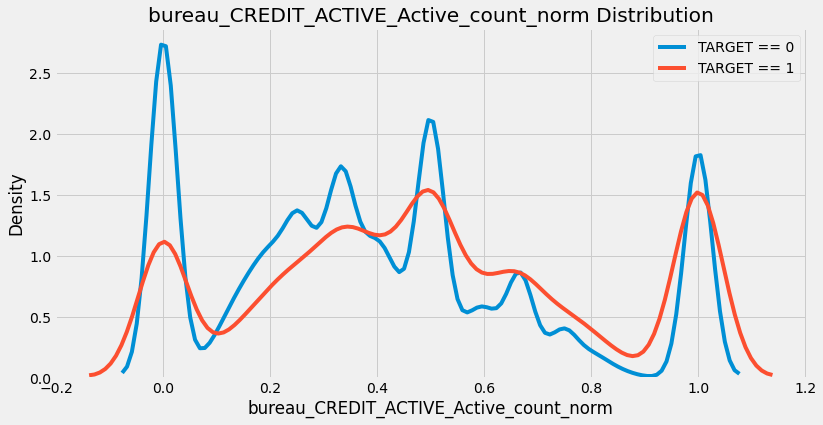

In [0]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

## Collinear Variables(공선 변수)

 우리는 타겟과 변수 간의 상관 관계뿐만 아니라 각 변수와 다른 모든 변수의 상관 관계도 계산할 수 있습니다. 이를 통해 데이터에서 제거해야 할 높은 공선 변수가 있는지 확인할 수 있습니다.

다른 변수와의 상관관계가 0.8보다 큰 변수는 없는지 알아보겠습니다.

In [0]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [0]:
corrs.shape

(317, 317)

상관 관계가 노ㅠ은 각 변수 쌍에 대해 하나의 변수만 제거하려고 합니다. 다음 코드는 각 쌍 중 하나만 추가하여 제거할 변수 집합을 만듭니다.

In [0]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


 training, testing 데이터셋에서 이 컬럼을 제거할 수 있습니다. 변수를 제거한 성능과 변수를 유지한 성능(이전에 저장한 raw csv 파일)을 비교해야 합니다.

In [0]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [0]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

# 모델링

이러한 새로운 데이터 세트의 성능을 실제로 테스트하기 위해 머신러닝에 사용해 보겠습니다. 여기서 우리는 다른 notebook에서 개발한 함수을 사용하여 feature을 비교할 것입니다(상관 관계가 큰 변수가 제거된 raw version). 우리는 실험처럼 실행할 수 있습니다. `control`은 competition에 제출될 때 이 함수에 있는 applicaion 데이터만 사용한 성능입니다. 이미 이 성능을 이 성능을 기록했으므로 `control`과 두 가지 `test` 조건을 나열하겠습니다.

**모든 데이터 세트의 경우 아래 표시된 모델을 사용합니다.(정확한 하이퍼 파라미터).**

- control : `application` 파일의 데이터
- test one: `bureau`와 `bureau _balance`로 부터 기록된 모든 데이터와 `application`의 데이터
- test two: `bureau`와 `bureau _balance`로부터 기록된 높은 상관 관계를 가진 변수가 제거된 모든 데이터와 `application` 데이터

In [0]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [0]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [0]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df


### [Control](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Control)

 실험의 첫 번째 단계 `control`을 설정하는 것입니다. 이를 위해서 우리는 위에서 정의한 함수(Gradient Boosting Machine 모델 구현)와 단일 메인 데이터 소스(`application`)을 사용할 것입니다.

In [0]:
train_control  = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/application_train.csv')
test_control = pd.read_csv('/content/drive/My Drive/JustKaggle/home-credit-risk/application_test.csv')

 다행이도, 일단 시간을 들여서 어떤 함수를 작성하게 되면, 그것을 사용하는 것은 간단합니다.(이 notebook에 중심 테마가 있다면, 그것은 일을 단순하고 다시 만들 수 있도록 하기 위해 함수를 사용하는 것입니다). 위의 함수는  competition에 업로드할 수 있는 제출용 데이터프레임과 feature 중요도의 `fi` 데이터프레임과 validation 및 테스트 성능을 가진 metric 데이터프레임을 반환합니다.

In [0]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798103	train's binary_logloss: 0.548552	valid's auc: 0.760007	valid's binary_logloss: 0.561913
Early stopping, best iteration is:
[269]	train's auc: 0.809199	train's binary_logloss: 0.537755	valid's auc: 0.760273	valid's binary_logloss: 0.555207
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798328	train's binary_logloss: 0.54852	valid's auc: 0.76114	valid's binary_logloss: 0.566651
Early stopping, best iteration is:
[289]	train's auc: 0.812654	train's binary_logloss: 0.534422	valid's auc: 0.761398	valid's binary_logloss: 0.558103
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.79964	train's binary_logloss: 0.54685	valid's auc: 0.750232	valid's binary_logloss: 0.564639
Early stopping, best iteration is:
[265]	train's auc: 0.809734	train's binary_logloss: 0.53678	

In [0]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


 training 점수가 validation 점수보다 높기 때문에 `control`은 약간 과적합됩니다. 정규화를 보면 이후 notebook에서 이 문제를 해결할 수 있습니다.(우리는 이미 이 모델에서 일직 정지한 것처럼 `reg_lambda`와 `reg_alpha`를 사용하여 약간의 정규화를 수행했습니다.)

우리는 다른 함수 `plot_feature_importances`를 이용하여 feature 중요도를 시각화할 수 있습니다. feature 중요도는 feature selection을 할 때 유용할 수 있습니다.

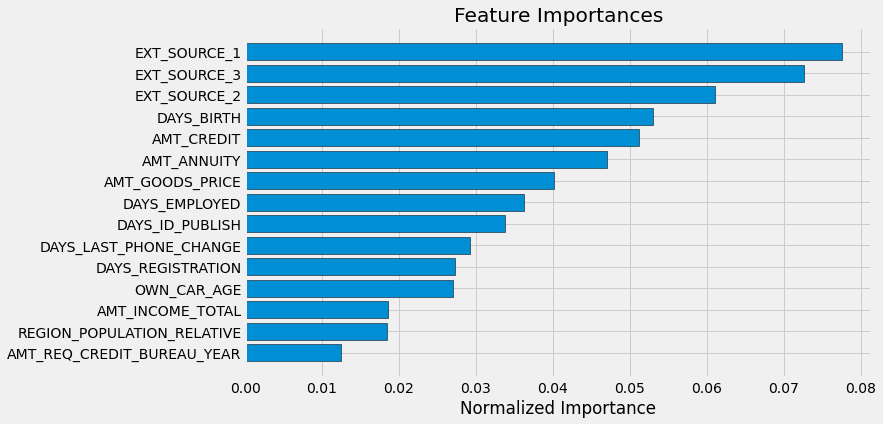

In [0]:
fi_sorted = plot_feature_importances(fi)

In [0]:
submission.to_csv('control.csv', index = False)

**The control scores 0.745 when submitted to the competition.**

### Test One

첫 번째 test를 수행해 봅시다. 대부분의 작업을 수행하는 함수에 데이터를 전달하기만 하면 됩니다.


In [0]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.810385	train's binary_logloss: 0.537173	valid's auc: 0.766471	valid's binary_logloss: 0.552795
Early stopping, best iteration is:
[293]	train's auc: 0.827287	train's binary_logloss: 0.519987	valid's auc: 0.767203	valid's binary_logloss: 0.541991
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.810288	train's binary_logloss: 0.537072	valid's auc: 0.767523	valid's binary_logloss: 0.557044
Early stopping, best iteration is:
[265]	train's auc: 0.822264	train's binary_logloss: 0.525006	valid's auc: 0.768109	valid's binary_logloss: 0.549333
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.811653	train's binary_logloss: 0.535599	valid's auc: 0.761029	valid's binary_logloss: 0.553525
Early stopping, best iteration is:
[267]	train's auc: 0.824147	train's binary_logloss: 0.52

In [0]:
metrics_raw

,fold,train,valid
0,0,0.827287,0.767203
1,1,0.822264,0.768109
2,2,0.824147,0.761625
3,3,0.816322,0.768150
4,4,0.828518,0.767902
5,overall,0.823708,0.766597


 이러한 수치를 바탕으로 engineer된 feature는 `control`의 경우보다 좋은 성능을 보입니다. 그러나 이렇게 향상된 validation 성능이 테스트 데이터로 전달되는지 확인하기 전에 예측 결과를 리더보드에 제출해야 합니다.

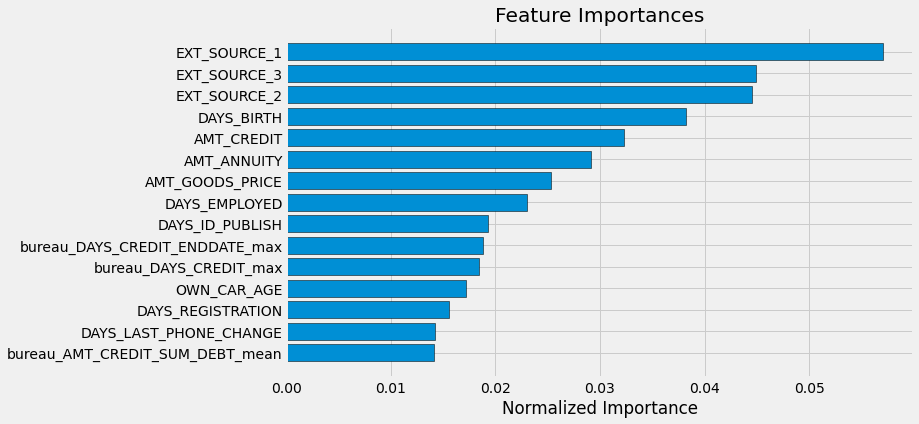

In [0]:
fi_raw_sorted = plot_feature_importances(fi_raw)

 feature 중요도를 살펴보면, 우리가 구성한 feature의 몇 가지가 가장 중요한 것 같습니다. 이 notebook에서 만든 가장 중요한 feature top 100의 비율을 찾아보겠습니다. 그러나 단순히 원래 feature를 비교하는 것보다는 one-hot 인코딩된 feature를 비교해야 합니다. 이러한 내용은 (원래 데이터에서) 이미 `fi`로 기록되어 있습니다.

In [0]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 53.00


상위 100개 기능 중 절반 이상을 우리가 만들어졌습니다! 그렇게 되면 우리가 한 모든 노력이 가치가 있다는 확신을 갖게 될 것입니다.

In [0]:
submission_raw.to_csv('test_one.csv', index = False)

**Test one scores 0.759 when submitted to the competition.**

### Test Two

 그것은 쉬우니 다른 것을 수행하겠습니다! 이전과 동일하지만 공선 변수가 제거되어 있습니다.

In [0]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.8063	train's binary_logloss: 0.540969	valid's auc: 0.764122	valid's binary_logloss: 0.555617
Early stopping, best iteration is:
[264]	train's auc: 0.817897	train's binary_logloss: 0.529406	valid's auc: 0.764565	valid's binary_logloss: 0.548248
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.806611	train's binary_logloss: 0.54063	valid's auc: 0.7652	valid's binary_logloss: 0.559872
[400]	train's auc: 0.839251	train's binary_logloss: 0.507787	valid's auc: 0.765625	valid's binary_logloss: 0.539423
Early stopping, best iteration is:
[379]	train's auc: 0.836334	train's binary_logloss: 0.510784	valid's auc: 0.765829	valid's binary_logloss: 0.5413
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.808063	train's binary_logloss: 0.538899	valid's auc: 0.757092	valid's binary_

In [0]:
metrics_corr

,fold,train,valid
0,0,0.817897,0.764565
1,1,0.836334,0.765829
2,2,0.807627,0.757149
3,3,0.821551,0.764810
4,4,0.825298,0.764449
5,overall,0.821741,0.763352


이러한 결과는 `control`보다 좋지만 raw feature보다 약간 낮습니다.

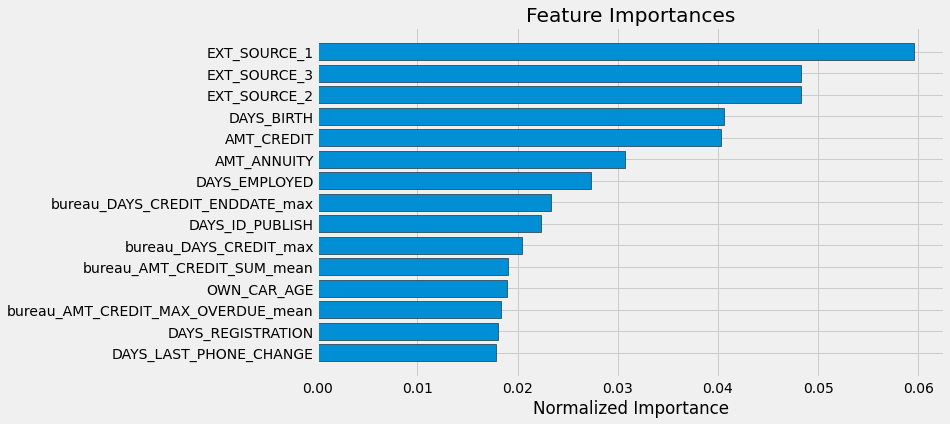

In [0]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [0]:
submission_corrs.to_csv('test_two.csv', index = False)

**Test Two scores 0.753 when submitted to the competition.**

# Results

 모든 작업이 끝난후, 추가 정보를 포함하면 성능이 향상되었다고 말할 수 있습니다. 모델은 데이터에 최적화되지 않았지만 계산된 feature를 사용할 때 원래 데이터셋에 비해 눈에 띄게 개선되었습니다. 공식적으로 성능을 요약해보겠습니다.

|Experiment | Train AUC | Validation AUC | Test AUC|
|--- | --- | --- | ---|
|Control|0.815|0.760|0.745|
|Test One|0.837|0.767|0.759|
|Test Two|0.826|0.765|0.753|

(이러한 점수는 notebook 실행에서 실행으로 바뀔 수 있습니다. 그러나 일반으로 바뀌지 않았습니다.)

 우리의 모든 작업은 원래 테스트 데이터에 비해 0.014 ROC AUC가 약간 개선된 것으로 해석됩니다.colinear 변수를 제거하면 성능이 약간 감소되므로 다른 feature selection 방법을 고려해 보겠습니다. 또한 우리가 생성한 feature의 일부는 모델에서 가장 중요하다고 판단되는 feature라고 말할 수 있습니다.

 이와 같은 competition에서 이정도 규모의 개선도 리더보드에서 100등정도 올라가게 하기에 충분합니다. 이 notebook에서와 같이 수많은 작은 개선을 통해 점차적으로 더 나은 성능과 더 나은 성능을 얻을 수 있습니다. 저는 다른 사람들이 자신의 개선을 위해 이 결과를 사용할 것을 권장하며, 다른 사람들을 돕기 위해 이 단계들을 계속해서 문서화할 것입니다.
 

# Next Steps
 앞으로는 이제 이 notebook에서 개발한 함수를 다른 데이터셋에서 사용할 수 있습니다. 아직 모델에서 사용할 수 있는 4개의 다른 데이터 파일이 있습니다. 다음 notebook에서는 이러한 데이터 파일(Home Credit의 이전 대출에대한 정보가 포함되어 있음)의 정보를 training 데이터에 통합할 것입니다. 그리고 나서 동일한 모델을 제작하고 feature engineering의 영향을 알아내기 위해 더 많은 실험을 수행할 수 있습니다. 이 competition에는 더 많은 작업이 필요하며, 더 많은 성과를 거둘 수 있습니다! 다음 notebook에서 뵙겠습니다.